# Imports

In [50]:
import pandas as pd
import glob
import os
import json
import ast
import numpy as np
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


# Reading in Data

In [51]:
path_to_annotations = "/Users/abhinavtadikonda/Downloads/OPP-115/consolidation/threshold-0.75-overlap-similarity"
all_csv_files = glob.glob(os.path.join(path_to_annotations, "*.csv"))

In [52]:
df_list = []
column_names = ['Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8', 'Column9']

In [53]:
for csv_file in all_csv_files:
    temp_df = pd.read_csv(csv_file, header=None, names=column_names)
    temp_df["source_file"] = os.path.basename(csv_file)
    df_list.append(temp_df)
all_data = pd.concat(df_list, ignore_index=True)

In [54]:
all_data

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,source_file
0,C1543,test_category_labeling_highlight_fordham_aaaa,121,3828,0,Other,"{""Other Type"": {""endIndexInSegment"": 575, ""sta...",5/7/15,http://www.kraftrecipes.com/about/privacynotic...,746_kraftrecipes.com.csv
1,12378,test_category_labeling_highlight_fordham_bbbb,116,3828,0,Policy Change,"{""Change Type"": {""endIndexInSegment"": 36, ""sta...",5/7/15,http://www.kraftrecipes.com/about/privacynotic...,746_kraftrecipes.com.csv
2,13161,test_category_labeling_highlight_fordham_aaaa,121,3828,1,First Party Collection/Use,"{""Collection Mode"": {""endIndexInSegment"": -1, ...",5/7/15,http://www.kraftrecipes.com/about/privacynotic...,746_kraftrecipes.com.csv
3,13162,test_category_labeling_highlight_fordham_aaaa,121,3828,1,First Party Collection/Use,"{""Collection Mode"": {""endIndexInSegment"": -1, ...",5/7/15,http://www.kraftrecipes.com/about/privacynotic...,746_kraftrecipes.com.csv
4,13163,test_category_labeling_highlight_fordham_aaaa,121,3828,1,First Party Collection/Use,"{""Collection Mode"": {""endIndexInSegment"": -1, ...",5/7/15,http://www.kraftrecipes.com/about/privacynotic...,746_kraftrecipes.com.csv
...,...,...,...,...,...,...,...,...,...,...
19715,2392,test_category_labeling_highlight,84,3631,27,Other,"{""Other Type"": {""endIndexInSegment"": 740, ""sta...",4/28/14,http://taylorswift.com/taylor-privacy-policy/,1545_taylorswift.com.csv
19716,2953,test_category_labeling_highlight,82,3631,27,International and Specific Audiences,"{""Audience Type"": {""endIndexInSegment"": 740, ""...",4/28/14,http://taylorswift.com/taylor-privacy-policy/,1545_taylorswift.com.csv
19717,3119,test_category_labeling_highlight,88,3631,27,International and Specific Audiences,"{""Audience Type"": {""endIndexInSegment"": 740, ""...",4/28/14,http://taylorswift.com/taylor-privacy-policy/,1545_taylorswift.com.csv
19718,C117,test_category_labeling_highlight,82,3631,28,Other,"{""Other Type"": {""endIndexInSegment"": 303, ""sta...",4/28/14,http://taylorswift.com/taylor-privacy-policy/,1545_taylorswift.com.csv


In [55]:
all_data_filtered = all_data[['Column6', 'Column7', 'Column9']]
all_data_filtered.columns = ['categories', 'annotations', 'website']
all_data_filtered.head()

,categories,annotations,website
0,Other,"{""Other Type"": {""endIndexInSegment"": 575, ""sta...",http://www.kraftrecipes.com/about/privacynotic...
1,Policy Change,"{""Change Type"": {""endIndexInSegment"": 36, ""sta...",http://www.kraftrecipes.com/about/privacynotic...
2,First Party Collection/Use,"{""Collection Mode"": {""endIndexInSegment"": -1, ...",http://www.kraftrecipes.com/about/privacynotic...
3,First Party Collection/Use,"{""Collection Mode"": {""endIndexInSegment"": -1, ...",http://www.kraftrecipes.com/about/privacynotic...
4,First Party Collection/Use,"{""Collection Mode"": {""endIndexInSegment"": -1, ...",http://www.kraftrecipes.com/about/privacynotic...


# Data Cleaning

In [56]:
def convert_annotation(annotation_str):
    try:
        return json.loads(annotation_str)
    except json.JSONDecodeError:
        return ast.literal_eval(annotation_str)

In [57]:
all_data_filtered.annotations = all_data_filtered.annotations.apply(convert_annotation)

/var/folders/5y/ggv9kct15fg4_jf8q92pkfcm0000gn/T/ipykernel_33432/2414426689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_filtered.annotations = all_data_filtered.annotations.apply(convert_annotation)


In [58]:
all_data_filtered.annotations.iloc[0]

{'Other Type': {'endIndexInSegment': 575,
  'startIndexInSegment': 9,
  'selectedText': 'Effective Date: May 7, 2015 Kraft Site Privacy Notice This website is owned and operated by Kraft Foods Group, Inc. At Kraft, we recognize that visitors to our site may be concerned about the information they provide to us and how we handle that information. This Privacy Notice describes the types of information we collect from and about you when you visit this website (and the mobile optimized version of this website), how we may use and disclose such information, and your ability to control certain uses of it.',
  'value': 'Introductory/Generic'}}

In [59]:
def extract_selected_text(annotation_dict):
    selected_texts = []
    for key, details in annotation_dict.items():
        if isinstance(details, dict) and "selectedText" in details:
            if details['selectedText'] not in selected_texts:
                selected_texts.append(details["selectedText"])
    return selected_texts

In [60]:
all_data_filtered['selected_text'] = all_data_filtered.annotations.apply(extract_selected_text)
all_data_filtered

/var/folders/5y/ggv9kct15fg4_jf8q92pkfcm0000gn/T/ipykernel_33432/3583976791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_filtered['selected_text'] = all_data_filtered.annotations.apply(extract_selected_text)


,categories,annotations,website,selected_text
0,Other,"{'Other Type': {'endIndexInSegment': 575, 'sta...",http://www.kraftrecipes.com/about/privacynotic...,"[Effective Date: May 7, 2015 Kraft Site Privac..."
1,Policy Change,"{'Change Type': {'endIndexInSegment': 36, 'sta...",http://www.kraftrecipes.com/about/privacynotic...,"[Effective Date: May 7, 2015]"
2,First Party Collection/Use,"{'Collection Mode': {'endIndexInSegment': -1, ...",http://www.kraftrecipes.com/about/privacynotic...,"[collec, register on our website or participat..."
3,First Party Collection/Use,"{'Collection Mode': {'endIndexInSegment': -1, ...",http://www.kraftrecipes.com/about/privacynotic...,"[collec, register on our website or participat..."
4,First Party Collection/Use,"{'Collection Mode': {'endIndexInSegment': -1, ...",http://www.kraftrecipes.com/about/privacynotic...,"[collec, register on our website or participat..."
...,...,...,...,...
19715,Other,"{'Other Type': {'endIndexInSegment': 740, 'sta...",http://taylorswift.com/taylor-privacy-policy/,[We comply with the United States privacy laws...
19716,International and Specific Audiences,"{'Audience Type': {'endIndexInSegment': 740, '...",http://taylorswift.com/taylor-privacy-policy/,[We comply with the United States privacy laws...
19717,International and Specific Audiences,"{'Audience Type': {'endIndexInSegment': 740, '...",http://taylorswift.com/taylor-privacy-policy/,"[By using the Sites, visitors to the Sites fro..."
19718,Other,"{'Other Type': {'endIndexInSegment': 303, 'sta...",http://taylorswift.com/taylor-privacy-policy/,[If you have any questions about either this P...


In [61]:
all_data_filtered_model = all_data_filtered[['categories', 'selected_text', 'website']]
all_data_filtered_model

,categories,selected_text,website
0,Other,"[Effective Date: May 7, 2015 Kraft Site Privac...",http://www.kraftrecipes.com/about/privacynotic...
1,Policy Change,"[Effective Date: May 7, 2015]",http://www.kraftrecipes.com/about/privacynotic...
2,First Party Collection/Use,"[collec, register on our website or participat...",http://www.kraftrecipes.com/about/privacynotic...
3,First Party Collection/Use,"[collec, register on our website or participat...",http://www.kraftrecipes.com/about/privacynotic...
4,First Party Collection/Use,"[collec, register on our website or participat...",http://www.kraftrecipes.com/about/privacynotic...
...,...,...,...
19715,Other,[We comply with the United States privacy laws...,http://taylorswift.com/taylor-privacy-policy/
19716,International and Specific Audiences,[We comply with the United States privacy laws...,http://taylorswift.com/taylor-privacy-policy/
19717,International and Specific Audiences,"[By using the Sites, visitors to the Sites fro...",http://taylorswift.com/taylor-privacy-policy/
19718,Other,[If you have any questions about either this P...,http://taylorswift.com/taylor-privacy-policy/


# Data Modeling

## Train Test Split

In [62]:
df = all_data_filtered_model.copy()
unique_websites = df["website"].unique()

In [63]:
np.random.seed(42)
np.random.shuffle(unique_websites)

In [64]:
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1 

In [65]:
n_total = len(unique_websites)
n_train = int(train_frac * n_total)
n_val = int(val_frac * n_total)

In [66]:
train_websites = unique_websites[:n_train]
val_websites = unique_websites[n_train : n_train + n_val]
test_websites = unique_websites[n_train + n_val :]

In [67]:
train_df = df[df["website"].isin(train_websites)].reset_index(drop=True)
val_df = df[df["website"].isin(val_websites)].reset_index(drop=True)
test_df = df[df["website"].isin(test_websites)].reset_index(drop=True)

In [68]:
print("Train websites:", len(train_websites))
print("Val websites:", len(val_websites))
print("Test websites:", len(test_websites))

print("Train samples:", len(train_df))
print("Val samples:", len(val_df))
print("Test samples:", len(test_df))

Train websites: 92
Val websites: 11
Test websites: 12
Train samples: 15757
Val samples: 1968
Test samples: 1995


In [69]:
all_categories = df["categories"].unique()
label2id = {cat: i for i, cat in enumerate(all_categories)}
id2label = {i: cat for cat, i in label2id.items()}

In [70]:
label2id

{'Other': 0,
 'Policy Change': 1,
 'First Party Collection/Use': 2,
 'User Choice/Control': 3,
 'Third Party Sharing/Collection': 4,
 'Data Retention': 5,
 'Do Not Track': 6,
 'International and Specific Audiences': 7,
 'Data Security': 8,
 'User Access, Edit and Deletion': 9}

In [71]:
# change categories to nums 
train_df["label"] = train_df["categories"].apply(lambda x: label2id[x])
val_df["label"] = val_df["categories"].apply(lambda x: label2id[x])
test_df["label"] = test_df["categories"].apply(lambda x: label2id[x])

In [72]:
train_texts = train_df["selected_text"].tolist()
train_labels = train_df["label"].tolist()

val_texts = val_df["selected_text"].tolist()
val_labels = val_df["label"].tolist()

test_texts = test_df["selected_text"].tolist()
test_labels = test_df["label"].tolist()

## NLP Model 

## Switch to GPU

In [73]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


## Baseline Models

In [78]:
num_labels = len(label2id)

In [82]:
train_texts_str = [" ".join(pieces) for pieces in train_texts]
val_texts_str   = [" ".join(pieces) for pieces in val_texts]
test_texts_str  = [" ".join(pieces) for pieces in test_texts]

### Dummy Classifer

In [ ]:
dummy_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),  
    ("clf",   DummyClassifier(strategy="most_frequent"))
])
dummy_pipe.fit(train_texts_str, train_labels)
y_dummy = dummy_pipe.predict(test_texts_str)

In [83]:
print(classification_report(
    test_labels,
    y_dummy,
    target_names=[id2label[i] for i in range(len(id2label))]
))
print("Dummy Macro F1:", f1_score(test_labels, y_dummy, average="macro"))


                                      precision    recall  f1-score   support

                               Other       0.00      0.00      0.00       267
                       Policy Change       0.00      0.00      0.00        50
          First Party Collection/Use       0.42      1.00      0.59       831
                 User Choice/Control       0.00      0.00      0.00       168
      Third Party Sharing/Collection       0.00      0.00      0.00       448
                      Data Retention       0.00      0.00      0.00        33
                        Do Not Track       0.00      0.00      0.00         7
International and Specific Audiences       0.00      0.00      0.00        47
                       Data Security       0.00      0.00      0.00        61
      User Access, Edit and Deletion       0.00      0.00      0.00        83

                            accuracy                           0.42      1995
                           macro avg       0.04      0.10     

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Log Reg Classifier

In [ ]:
logreg_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10_000, ngram_range=(1,2))),
    ("clf",   LogisticRegression(
                  max_iter=1000,
                  class_weight="balanced",
                  n_jobs=-1
              ))
])
logreg_pipe.fit(train_texts_str, train_labels)
y_logreg = logreg_pipe.predict(test_texts_str)

In [84]:
print(classification_report(
    test_labels,
    y_logreg,
    target_names=[id2label[i] for i in range(len(id2label))]
))
print("LogReg Macro F1:", f1_score(test_labels, y_logreg, average="macro"))

                                      precision    recall  f1-score   support

                               Other       0.79      0.54      0.64       267
                       Policy Change       0.79      0.92      0.85        50
          First Party Collection/Use       0.86      0.81      0.83       831
                 User Choice/Control       0.60      0.79      0.68       168
      Third Party Sharing/Collection       0.74      0.80      0.77       448
                      Data Retention       0.53      0.64      0.58        33
                        Do Not Track       1.00      1.00      1.00         7
International and Specific Audiences       0.67      0.83      0.74        47
                       Data Security       0.63      0.72      0.67        61
      User Access, Edit and Deletion       0.66      0.72      0.69        83

                            accuracy                           0.76      1995
                           macro avg       0.73      0.78     

## BERT Sequence Classification

In [76]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [79]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
class PrivacyPolicyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {key: val.squeeze() for key, val in encoding.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

In [42]:
train_dataset = PrivacyPolicyDataset(train_texts, train_labels, tokenizer)
val_dataset = PrivacyPolicyDataset(val_texts, val_labels, tokenizer)
test_dataset = PrivacyPolicyDataset(test_texts, test_labels, tokenizer)

In [43]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    f1 = f1_score(labels, predictions, average="macro")
    return {"f1": f1}

In [44]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",      
    eval_steps=100,                   
    logging_strategy="steps",
    logging_steps=100,               
    save_strategy="steps",
    save_steps=100,
    num_train_epochs=1,             
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    load_best_model_at_end=True,
)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1
100,1.258100,0.789958,0.352197
200,0.692900,0.520492,0.519631
300,0.504800,0.451815,0.688804
400,0.462700,0.398012,0.719946
500,0.384300,0.340912,0.762448
600,0.326700,0.335576,0.761050
700,0.344100,0.311741,0.819969
800,0.292600,0.301343,0.840934
900,0.249200,0.287702,0.850673


TrainOutput(global_step=985, training_loss=0.4832946854799532, metrics={'train_runtime': 1537.9622, 'train_samples_per_second': 10.245, 'train_steps_per_second': 0.64, 'total_flos': 1036534672492032.0, 'train_loss': 0.4832946854799532, 'epoch': 1.0})

## Test Set Eval

In [45]:
test_results = trainer.evaluate(eval_dataset=test_dataset)
print("Test results:", test_results)

In [46]:
pred_output = trainer.predict(test_dataset)
preds = np.argmax(pred_output.predictions, axis=1)
true_labels = pred_output.label_ids

Confusion Matrix:
[[243   1   3   0   1   0   0   8   9   2]
 [  7  37   0   1   4   0   0   0   0   1]
 [  4   0 794   6  20   5   0   0   0   2]
 [  4   1   5 153   1   0   0   0   0   4]
 [  2   0  22   1 421   0   0   0   1   1]
 [  0   0   3   0   0  28   0   0   1   1]
 [  2   0   0   0   0   0   4   0   1   0]
 [  4   0   0   0   1   0   0  41   0   1]
 [ 16   0   2   0   0   0   0   0  43   0]
 [  3   0   3   5   2   0   0   1   0  69]]

Classification Report:
                                      precision    recall  f1-score   support

                               Other       0.85      0.91      0.88       267
                       Policy Change       0.95      0.74      0.83        50
          First Party Collection/Use       0.95      0.96      0.95       831
                 User Choice/Control       0.92      0.91      0.92       168
      Third Party Sharing/Collection       0.94      0.94      0.94       448
                      Data Retention       0.85      0.85 

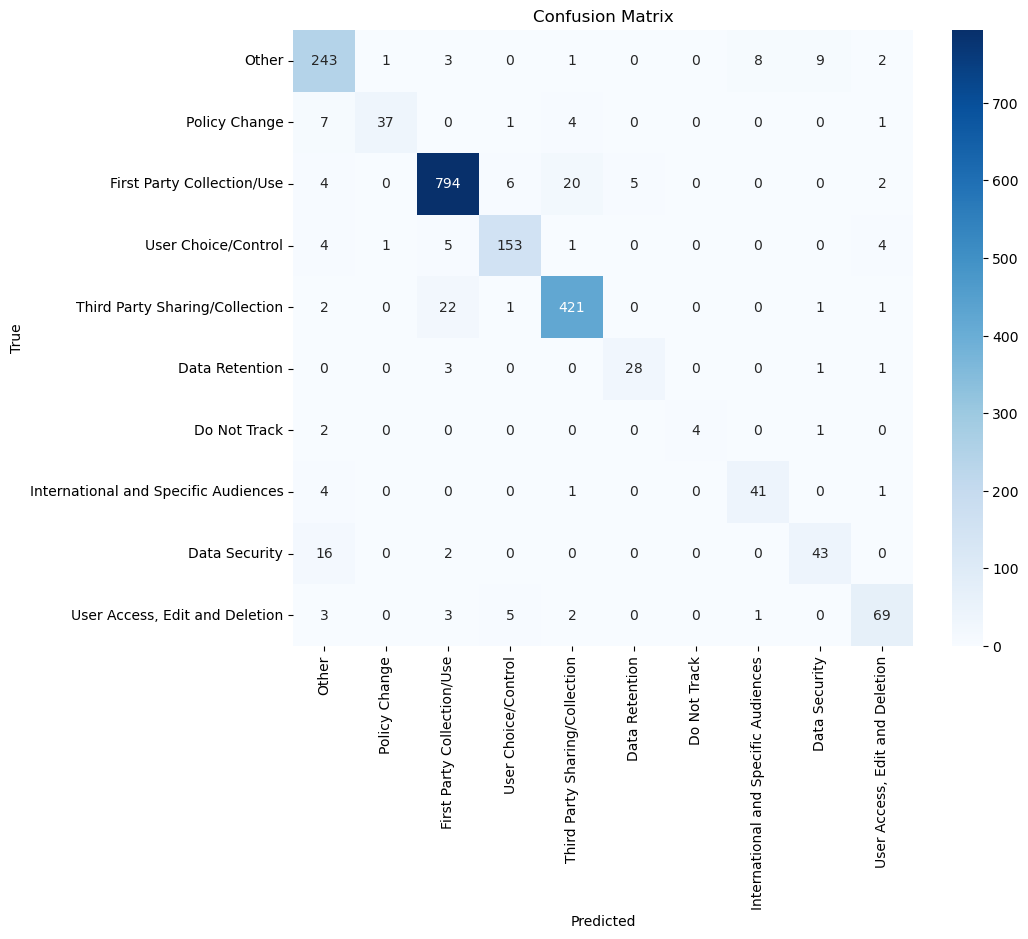

In [25]:
cm = confusion_matrix(true_labels, preds)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=[id2label[i] for i in range(num_labels)]))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[id2label[i] for i in range(num_labels)],
            yticklabels=[id2label[i] for i in range(num_labels)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
